In [2]:
import numpy as np
import cvxpy as cp
import gurobipy as gp
import pandas as pd
import mosek
import matplotlib.pyplot as plt
import phi_divergence as phi
from scipy.optimize import fsolve
import scipy.stats
from itertools import chain, combinations
import time
from datetime import datetime as dt
import scipy.stats


In [3]:
def generate_data_mohajerin2018(N, k):   ##### Code for generating portfolio return data's
    np.random.seed(1)
    sys_risk_mean = 0
    sys_risk_stdev = 0.02
    unsys_risk_mean = np.fromiter(((i * 0.03) for i in range(1,k+1)), float)
    unsys_risk_stdev = np.fromiter(( i * 0.025 for i in range(1,k+1)), float)
    data = np.empty([N,k])
    for n in range(0, N):
        sys_return = np.random.normal(sys_risk_mean, sys_risk_stdev)
        for i in range(0, k):
            unsys_return = np.random.normal(unsys_risk_mean[i], unsys_risk_stdev[i])
            data[n, i] = sys_return + unsys_return
    return data 

In [4]:
def Prelec(x,a,b):
    if x == 0:
        return(0)
    else:
        return((np.exp(-(-np.log(x))**a))**b)


In [5]:
def make_slope_ic(x_d, y_d):
    slope = np.zeros(len(x_d)-1)
    for i in range(1,len(slope)+1):
        slope[i-1] = (y_d[i]-y_d[i-1])/(x_d[i]-x_d[i-1])
    i0 = np.where(np.diff(slope)>=0)[0][0]   #### slope[i0] is the last concave slope
    x_d1 = x_d[0:(i0)+2]   #### (x_d[0],....,x_d[i0+1]) are the x-points of all concave part
    y1 = y_d[0:(i0)+2]
    x_d2 = np.sort(1-x_d[(i0)+1: len(x_d)])  #####  (x_d[i0+1],...., x_d[len(x_d)-1]) are the x-points of convex parts, 1-(...) sorted are that of
                                                                                        #### the dual functions bar{h}(p)=1-h(1-p)
    y2 = np.sort(1-y_d[(i0)+1: len(y_d)])
    slope1 = slope[0:(i0+1)]       #### select all the concave slopes: slope[0:(i0+1)]= (slope[0],....,slope[i0])
    slope2 = -np.sort(-slope[(i0+1):len(slope)])   #### The slopes of the dual-concave functions are 
                                                            ### the convex slopes (slope[i0+1],...,slope[len(slope)-1]) sorted backwards
    ic1 = np.zeros(len(slope1))
    ic2 = np.zeros(len(slope2))
    for i in range(len(slope1)):
        ic1[i] = y1[i] - slope1[i]*x_d1[i]

    for i in range(len(slope2)):
        ic2[i] = y2[i] - slope2[i]*x_d2[i]
    h_po = y1[len(y1)-1]
    h_hat = y2[len(y2)-1]
    return(slope1, ic1, slope2,ic2,h_po, h_hat,slope)
    
    

In [6]:
def S_distortion_opt(R,prob,slope1,ic1,slope2,ic2,h_po,h_hat):
    md = gp.Model("S_distortion")
    m = len(R)
    n_a = len(R[0])
    K1 = len(slope1)
    K2 = len(slope2)
    n_it = len(prob)
    beta = md.addVar(-gp.GRB.INFINITY)
    a = md.addVars(n_a)
    qb = md.addVars(m) 
    nu = md.addVars(K1)
    lbda = md.addVars(m, K1)
    t_ik = md.addVars(m, K2)
    md.addConstr(gp.quicksum(qb[i] for i in range(m)) == h_hat)
    md.addConstr(gp.quicksum(a[i] for i in range(n_a)) == 1)
    md.addConstrs((lbda[i,k] <= nu[k] for k in range(K1) for i in range(m)))
    md.addConstrs(gp.quicksum(-R[i,j]* a[j] for j in range(n_a))-1 -\
                      beta - gp.quicksum(lbda[i,k] for k in range(K1)) <= 0 for i in range(m))
    obj1 = beta*h_po + gp.quicksum(nu[k]*ic1[k] for k in range(K1)) + gp.quicksum(lbda[i,k]*prob[i]*slope1[k]\
                                            for k in range(K1) for i in range(m))
    md.addConstrs((qb[i] <= slope2[k]*prob[i] + t_ik[i,k] for k in range(K2) for i in range(m)))
    md.addConstrs(gp.quicksum(t_ik[i,k] for i in range(m)) <= ic2[k] for k in range(K2))
    md.setObjective(obj1 + gp.quicksum(-qb[i] * (gp.quicksum(a[j] * R[i, j] for j in range(n_a)) + 1) for i in range(m)), gp.GRB.MINIMIZE)
    md.params.NonConvex = 2
    md.params.OutputFlag = 0
    md.optimize()
    a_val = md.getAttr("X", a)
    return(md.objVal, np.array(a_val.values()), md.MIPGap*np.abs(md.objVal))

In [7]:
def S_dist_iterate(R,prob,slope1,ic1,slope2,ic2,h_po, h_hat):
    md = gp.Model("S_distortion")
    #md.params.MIPGap = 1e-7
    m = len(R)
    n_a = len(R[0])
    K1 = len(slope1)
    K2 = len(slope2)
    n_it = len(prob)
    u = md.addVars(n_it, lb = -gp.GRB.INFINITY)
    t_max = md.addVar(-gp.GRB.INFINITY)
    beta = [md.addVar(-gp.GRB.INFINITY) for i in range(n_it)]
    a = md.addVars(n_a)
    qb = [md.addVars(m) for i in range(n_it)] 
    nu = [md.addVars(K1) for i in range(n_it)]
    lbda = [md.addVars(m, K1) for i in range(n_it)]
    t_ik = [md.addVars(m, K2) for i in range(n_it)]
    for it in range(n_it):
        md.addConstr(gp.quicksum(qb[it][i] for i in range(m)) == h_hat)
        md.addConstr(gp.quicksum(a[i] for i in range(n_a)) == 1)
        md.addConstrs((lbda[it][i,k] <= nu[it][k] for k in range(K1) for i in range(m)))
        md.addConstrs(gp.quicksum(-R[i,j]* a[j] for j in range(n_a))-1 -\
                          beta[it] - gp.quicksum(lbda[it][i,k] for k in range(K1)) <= 0 for i in range(m))
        md.addConstr(beta[it]*h_po + gp.quicksum(nu[it][k]*ic1[k] for k in range(K1)) +\
                                         gp.quicksum(lbda[it][i,k]*prob[it][i]*slope1[k]\
                                                for k in range(K1) for i in range(m) if prob[it][i] >= 1e-11) <= u[it])
        for i in range(m):
            if prob[it][i]>= 1e-11:
                md.addConstrs((qb[it][i] <= slope2[k]*prob[it][i] + t_ik[it][i,k] for k in range(K2)))
            else:
                md.addConstrs((qb[it][i] <= t_ik[it][i,k] for k in range(K2)))
        md.addConstrs(gp.quicksum(t_ik[it][i,k] for i in range(m)) <= ic2[k] for k in range(K2))
        md.addConstr(u[it] + gp.quicksum(-qb[it][i]*(gp.quicksum(a[j]*R[i,j] for j in range(n_a))+1) for i in range(m)) <= t_max)
    md.setObjective(t_max, gp.GRB.MINIMIZE)
    md.params.NonConvex = 2
    md.params.OutputFlag = 0
    md.optimize()
    a_val = md.getAttr("X", a)
    u_val = md.getAttr("X", u)
    
    return(md.objVal, np.array(list(a_val.values())), md.MIPGap*np.abs(md.objVal))

In [8]:
def Robustness_S_dist(R,a,r,p,domain,value, quad):   #### Code for calculating robust evaluation of a single solution
                                                          ### quad = 1 for quadratic phi(t)=(t-1)^2, quad = 0 for phi(t)=|t-1|
    md = gp.Model("WCrob")
    m = len(p)
    N = len(domain)
    q = md.addVars(m)
    z = md.addVars(m)
    lambda_var = md.addVars(m, N)
    ind = np.argsort(-R.dot(a))
    x = -np.sort(-R.dot(a))
    dx = np.diff(-x)
    ind2 = np.argsort(ind)
    md.addConstr(gp.quicksum(q[i] for i in range(m)) == 1)
    if quad:
        md.addConstr(gp.quicksum(1/p[i]*(q[i] - p[i]) ** 2 for i in range(m)) <= r)
    else:
        s1 = md.addVars(m)                                        ##### These codes can be used when using phi(t)=|t-1|
        s2 = md.addVars(m, lb = -gp.GRB.INFINITY)
        md.addConstr(gp.quicksum(s1[i] for i in range(m)) <= r)
        md.addConstrs(s1[i] == gp.abs_(s2[i]) for i in range(m))
        md.addConstrs(s2[i] == p[i]-q[i] for i in range(m))

        
    for i in range(m):
        sos2_indices = list(range(N))
        md.addSOS(gp.GRB.SOS_TYPE2, [lambda_var[i, j] for j in sos2_indices])
        md.addConstr(gp.quicksum(lambda_var[i,j] for j in sos2_indices) == 1)
        if i > 0:
            md.addConstr(gp.quicksum(lambda_var[i,j] * domain[j] for j in sos2_indices)== gp.quicksum(q[k] for k in range(i,m)))
            md.addConstr(z[i] == gp.quicksum(lambda_var[i,j] * value[j] for j in sos2_indices))
    dx2 = np.concatenate(([0],dx))
    objective_expr = -x[0] + gp.quicksum(z[i] * dx2[i] for i in range(1,m))
    md.setObjective(objective_expr, gp.GRB.MAXIMIZE)
    md.params.OutputFlag = 0
    #md.setParam('FeasibilityTol', 1e-9)

    md.optimize()
    obj_pw = md.objVal
    q_val = md.getAttr("X", q)
    q_val = np.array(list(q_val.values()))
    return(obj_pw-1, q_val[ind2])

In [9]:
def cutting_plane_Sdist(R,p,r,eps,slope1,ic1,slope2,ic2,h_po, h_hat, domain,value,it, quad):   #### Code solving robust portfolio
    gap = np.inf
    prob = [p]
    i = 0
    while gap > eps and i<= it:
        [obj,a_s,mip_gap] = S_dist_iterate(R,prob,slope1,ic1,slope2,ic2,h_po, h_hat)
        print('lb:',obj, 'lb_precision:',mip_gap)
        [wc, q_wc] = Robustness_S_dist(R,a_s,r,p,domain,value, quad) 
        gap = wc - obj
        print('ub:',wc, 'iter:', i, 'gap', gap)
        prob.append(q_wc)
        i = i + 1
    print(np.sum((q_wc-p)**2/p), np.sum(q_wc), np.min(q_wc))
    return('sol:',a_s, 'lb:',obj, 'ub:', obj + gap)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


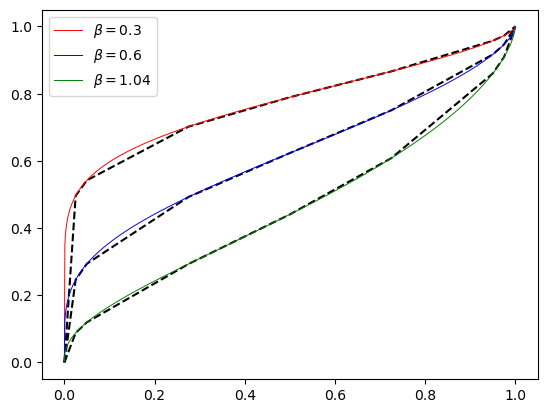

In [10]:
delta = 0.05
# Discrete set x_d
x_d = np.concatenate((np.arange(0, 0.05, 0.05 / 2), 
                       np.arange(0.05, 0.95, (0.95 - 0.05) / 4), 
                       np.arange(0.95, 1, 0.05 / 2)))

# Finer discrete set x_dd
x_dd = np.arange(0, 1 + 0.001, 0.001)

# Preallocate arrays for the coarse set
y_d = np.zeros(len(x_d))
y_d2 = np.zeros(len(x_d))
y_d3 = np.zeros(len(x_d))

# Preallocate arrays for the finer set
y_dd = np.zeros(len(x_dd))
y_dd2 = np.zeros(len(x_dd))
y_dd3 = np.zeros(len(x_dd))

# Compute the Prelec values for the coarse set
for i in range(len(x_d)):
    y_d[i] = Prelec(x_d[i], 0.65, 0.3)
    y_d2[i] = Prelec(x_d[i], 0.65, 0.6)
    y_d3[i] = Prelec(x_d[i], 0.65, 1.04)

# Compute the Prelec values for the finer set
for i in range(len(x_dd)):
    y_dd[i] = Prelec(x_dd[i], 0.65, 0.3)
    y_dd2[i] = Prelec(x_dd[i], 0.65, 0.6)
    y_dd3[i] = Prelec(x_dd[i], 0.65, 1.04)

# Plot the coarse set
plt.plot(x_d, y_d, color='black', linestyle='--',linewidth=1.5)
plt.plot(x_d, y_d2, color='black',  linestyle='--',linewidth=1.5)
plt.plot(x_d, y_d3, color='black',  linestyle='--',linewidth=1.5)

# Plot the finer set
plt.plot(x_dd, y_dd, color='red',label=r'$\beta = 0.3$', linestyle='-', linewidth=0.7)
plt.plot(x_dd, y_dd2, color='blue', label=r'$\beta = 0.6$', linestyle='-', linewidth=0.7)
plt.plot(x_dd, y_dd3, color='green', label=r'$\beta = 1.04$', linestyle='-', linewidth=0.7)

# Add legend and save the figure
plt.legend()
plt.savefig('Prelecs.eps', format='eps')


In [11]:
np.random.seed(1)
R = generate_data_mohajerin2018(100, 5)
m = len(R)
p = np.zeros(m)+1/m
prob = p
r = 1/(m)*scipy.stats.chi2.ppf(0.95, m-1)  

In [ ]:
#### The case of beta = 0.3
[slope1, ic1, slope2,ic2,h_po, h_hat,slope] = make_slope_ic(x_d, y_d)

#### Solve nominal problem:
t1 = time.time()
res = S_distortion_opt(R,p,slope1,ic1,slope2,ic2,h_po,h_hat)   #### Running this code requires Gurobi License
t2 = time.time()
print('nominal solution')
print('obj:', res[0], 'sol:', res[1], 'precision:', res[2])
print('time:',t2-t1)

#### Solve robust problem
eps = 0.001                     
it = 30
quad = 1    #### 1 if phi(t)=(t-1)^2, 0 if phi(t)=|t-1|
t_b = time.time()
print('robust solution')
print(cutting_plane_Sdist(R,p,r,eps,slope1,ic1,slope2,ic2,h_po, h_hat, x_d,y_d,it,quad))
t_e = time.time()
print(t_e-t_b)

In [ ]:
#### The case of beta = 0.6
[slope1, ic1, slope2,ic2,h_po, h_hat,slope] = make_slope_ic(x_d, y_d2)

#### Solve nominal problem:
t1 = time.time()
res = S_distortion_opt(R,p,slope1,ic1,slope2,ic2,h_po,h_hat)   #### Running this code requires Gurobi License
t2 = time.time()
print('nominal solution')
print('obj:', res[0], 'sol:', res[1], 'precision:', res[2])
print('time:',t2-t1)

#### Solve robust problem
eps = 0.001                    
it = 30
quad = 1        #### 1 if phi(t)=(t-1)^2, 0 if phi(t)=|t-1|
t_b = time.time()
print('robust solution')
print(cutting_plane_Sdist(R,p,r,eps,slope1,ic1,slope2,ic2,h_po, h_hat, x_d,y_d2,it,quad))
t_e = time.time()
print(t_e-t_b)

In [ ]:
#### The case of beta = 1.04
[slope1, ic1, slope2,ic2,h_po, h_hat,slope] = make_slope_ic(x_d, y_d3)

#### Solve nominal problem:
t1 = time.time()
res = S_distortion_opt(R,p,slope1,ic1,slope2,ic2,h_po,h_hat)   #### Running this code requires Gurobi License
t2 = time.time()
print('nominal solution')
print('obj:', res[0], 'sol:', res[1], 'precision:', res[2])
print('time:',t2-t1)

#### Solve robust problem
eps = 0.001                     
it = 30
quad = 1      #### 1 if phi(t)=(t-1)^2, 0 if phi(t)=|t-1|
t_b = time.time()
print('robust solution')
print(cutting_plane_Sdist(R,p,r,eps,slope1,ic1,slope2,ic2,h_po, h_hat, x_d,y_d3,it,quad))
t_e = time.time()
print(t_e-t_b)